## 1. Set up

In [1]:
import pandas as pd
import os
import base64
import time
import pickle as p
import numpy as np
import matplotlib.pyplot as plt
import pandas.core.algorithms as algos
from sklearn.model_selection import train_test_split
from sklearn import metrics
from functools import reduce
import datetime
from dateutil.relativedelta import relativedelta
import logging
import matplotlib.style as style
import matplotlib
import matplotlib.lines as mlines
from matplotlib.ticker import FuncFormatter
style.use('seaborn')

import warnings
warnings.filterwarnings('ignore')

In [2]:
pd.set_option('display.max_rows', 500)
pd.set_option('display.max_columns', 500)
pd.set_option('display.width', 1000)

In [3]:
import gc
gc.collect()

51

## 2. Data Loading & Preprocessing

In [4]:
data_file_path = '../data/'

### 2.1 TPA & Client

In [5]:
# Client & TPA

TPA = pd.read_excel(data_file_path + 'Copy_of_TPA_cash.xlsx',sheet_name='Sheet1')
Client = pd.read_excel(data_file_path + 'Client_info_20191118.xlsx',sheet_name='Sheet1')
# 3 Clients have duplicates records
# Client[Client['Client ID'].isin([1500,7601,2449])]
Client = Client.drop(Client.index[[0,1,497]])


Client = Client.merge(TPA,how='left',left_on='Client ID',right_on='HOST ID')
Client['TPA'] = Client['TPA_x']
Client.loc[Client['TPA_x'].isnull(),'TPA'] = Client.loc[Client['TPA_x'].isnull(),'TPA_y']
Client['TPA'] = Client['TPA'].apply(lambda x: x.upper() if pd.notnull(x) else np.nan)
Client.drop(['TPA_x','TPA_y','HOST ID'],axis=1,inplace = True)

In [6]:
# You might want to delete TPA, uncomment following line
# del TPA

### 2.2 Customer

In [7]:
Customer_old = pd.read_csv(data_file_path + 'Customer_Data_Request_20191121.csv')
Customer = pd.read_csv(data_file_path + 'Customer_Data_Request_20191217.csv')
# Append these 2 dataframes together
Customer = Customer_old.append(Customer,ignore_index = True)


# 2 Customer has duplicating records, we pick ClientID 2049 as their real Client but this is just a random choice
# Customer[Customer['Unique_Customer_ID']==100541023,100696306]
# Drop the duplicates customerID by index
Customer = Customer.drop(Customer.index[[72898,51730]])

# This line is self-explained
Customer = Customer.replace('.', np.nan)


# ===================== #
# Formatting conversion #
# ===================== #
def f(x):
    """
    This is a function that takes in any string format variable
    and return it as uppercase format.
    
    """
    if pd.notnull(x):
        return x.upper()
    else:
        return np.nan

Customer['Street1'] = Customer['Street1'].apply(lambda x: f(x))
Customer['Street2'] = Customer['Street2'].apply(lambda x: f(x))
Customer['City'] = Customer['City'].apply(lambda x: f(x))
Customer['Status'] = Customer['Status'].apply(lambda x: f(x))

# Convert numeric columns to float type
Customer_numeric_columns = ['Customer_Salary','Customer_Tenure']
Customer[Customer_numeric_columns] = Customer[Customer_numeric_columns].astype(float)

# Convert date format columns to datetime type
Customer_date_columns = ['Enrollment_Date','Term_Date']
Customer[Customer_date_columns] = Customer[Customer_date_columns].astype(str).apply(pd.to_datetime, format='%m/%d/%Y')

# Some data cleaning here, eliminate the customers with following cases
# Customer_Salary has NaN, 0 and '.' ~11%
# Assigned_Spending_Limit has 0 ~7%
# Customer_Tenure has NaN

# Customer = Customer[(Customer['Assigned_Spending_Limit'] != 0) & 
#                     (Customer['Customer_Salary'] != 0) & 
#                     (Customer['Customer_Salary'].notnull())&
#                     (Customer['Customer_Tenure'].notnull())]




# Merge Customer dataset with Client by Company ID/Client ID
Customer = Customer.merge(Client,how='left',left_on='Unique_Company_ID',right_on='Client ID')
Customer.head()


,Unique_Customer_ID,Unique_Company_ID,Enrollment_Date,Assigned_Spending_Limit,Customer_Tenure,Customer_Salary,Prior_Customer_Flag,Street1,Street2,City,State,Zip,Status,Term_Date,Active,Client ID,Account Name,Current Eligibles,Eligibles at time of Launch,Industry,NAICS Code,NAICS Description,Broker,Launch Date,Termination Date,Affiliate/Fed Gov?,CLIENT CODE,CLIENT NAME,CLIENT AR,Cash,TPA
0,100001115,1000,2014-02-24,6880.0,230.0,58229.0,Repeat Buyer,1471 N EAST ST,NaN,YORK,PA,17406,EMPLOYED,NaT,Y,1000.0,SOCIAL SECURITY ADMINISTRATION,60000.0,70000.0,Federal Government/Associations,923130.0,"Administration of Social, Human Resource and I...",PPC,2002-07-01,NaT,Fed Gov,SSA,SOCIAL SECURITY ADMINISTRATION,KELLY MENCHINGER,TPA sends cash on behalf of client,EAA
1,100001120,1000,2014-02-24,6520.0,362.0,109245.0,Repeat Buyer,94 BRENTWOOD LN,NaN,VALLEY STREAM,NY,11581,EMPLOYED,NaT,Y,1000.0,SOCIAL SECURITY ADMINISTRATION,60000.0,70000.0,Federal Government/Associations,923130.0,"Administration of Social, Human Resource and I...",PPC,2002-07-01,NaT,Fed Gov,SSA,SOCIAL SECURITY ADMINISTRATION,KELLY MENCHINGER,TPA sends cash on behalf of client,EAA
2,100001141,1000,2014-02-25,10290.0,337.0,127226.0,Repeat Buyer,103 KENILWORTH PARK DR,APT 2B,TOWSON,MD,21204,EMPLOYED,NaT,Y,1000.0,SOCIAL SECURITY ADMINISTRATION,60000.0,70000.0,Federal Government/Associations,923130.0,"Administration of Social, Human Resource and I...",PPC,2002-07-01,NaT,Fed Gov,SSA,SOCIAL SECURITY ADMINISTRATION,KELLY MENCHINGER,TPA sends cash on behalf of client,EAA
3,100001158,1000,2014-02-24,5190.0,419.0,49375.0,Repeat Buyer,1036 BRADDISH AVE,NaN,BALTIMORE,MD,21216,EMPLOYED,NaT,Y,1000.0,SOCIAL SECURITY ADMINISTRATION,60000.0,70000.0,Federal Government/Associations,923130.0,"Administration of Social, Human Resource and I...",PPC,2002-07-01,NaT,Fed Gov,SSA,SOCIAL SECURITY ADMINISTRATION,KELLY MENCHINGER,TPA sends cash on behalf of client,EAA
4,100001169,1000,2014-02-24,7500.0,448.0,69460.0,Repeat Buyer,3915 W ROGERS AVE,NaN,BALTIMORE,MD,21215,EMPLOYED,NaT,Y,1000.0,SOCIAL SECURITY ADMINISTRATION,60000.0,70000.0,Federal Government/Associations,923130.0,"Administration of Social, Human Resource and I...",PPC,2002-07-01,NaT,Fed Gov,SSA,SOCIAL SECURITY ADMINISTRATION,KELLY MENCHINGER,TPA sends cash on behalf of client,EAA


In [8]:
print('{:.0%} of Customers have Assigned_Spending_Limit == 0'.format(Customer[Customer['Assigned_Spending_Limit']==0].shape[0]/Customer.shape[0]))
print('{:.0%} of Customers have missing Customer_Salary'.format(Customer[Customer['Customer_Salary'].isnull()].shape[0]/Customer.shape[0]))
print('{:.2%} of Customers have Customer_Salary == 0'.format(Customer[Customer['Customer_Salary']==0].shape[0]/Customer.shape[0]))
print('{:.2%} of Customers have missing Customer_Tenure'.format(Customer[Customer['Customer_Tenure'].isnull()].shape[0]/Customer.shape[0]))

7% of Customers have Assigned_Spending_Limit == 0
11% of Customers have missing Customer_Salary
0.25% of Customers have Customer_Salary == 0
0.02% of Customers have missing Customer_Tenure


### 2.3 Performance Dataset

In [9]:
Perf_11 = pd.read_csv(data_file_path + 'Performance_Data_Request_20191217.csv')
Perf = pd.read_csv(data_file_path + 'Performance_Data_Request_20191204.csv')
# Deal with the column name mismatching issue before appending the 2 dataframes together
Perf_11.rename(columns={' Unique_Order_ID': 'Unique_Order_ID',
                        'Order_date': 'Order_Date'}, inplace=True)
Perf.rename(columns={'items_ordered': 'Items_Ordered',
                     'EMPSTATUS': 'Customer_Status'}, inplace=True)
# Append these 2 dataframes together
Perf = Perf.append(Perf_11, ignore_index=True)

# This line is self-explained
Perf = Perf.replace('.', np.nan)

# ===================== #
# Formatting conversion #
# ===================== #
# Convert numeric columns to float type
Perf_numeric_columns = ['Order_Amount', 'Product_Markup', 'Payments_Due', 'Current_Balance', 'Losses', 
                   'Spending_Limit_at_time_of_Order', 'Tenure_at_time_of_Order','Salary_at_time_of_Order']
Perf[Perf_numeric_columns] = Perf[Perf_numeric_columns].astype(float)

# Convert date format columns to datetime type
Perf_date_columns = ['Date_account_went_delinquent','Order_Date']
Perf[Perf_date_columns] = Perf[Perf_date_columns].astype(str).apply(pd.to_datetime,format = '%m/%d/%Y' )


# Make sure the data order is aligned with OrderID & Y-M
Perf['Year_and_Month'] = pd.to_datetime(Perf['Year_and_Month'].astype(str), format='%Y%m')
Perf = Perf.sort_values(['Unique_Order_ID', 'Year_and_Month'], ascending=[False, True])

# ======================== #
# New Columns Construction #
# ======================== #

# Create YQ and Year
Perf['YQ'] = pd.PeriodIndex(Perf['Year_and_Month'], freq='Q')
Perf['Year'] = Perf['YQ'].dt.year

# Create Payment_Order by Unique_Order_ID and Year_and_Month
Perf['Payment_Order'] = Perf.groupby('Unique_Order_ID')['Year_and_Month'].rank(method='first')

# Create Bad Flag - Treat 151+ and CO as BAD
Perf['Bad'] = 0
Perf.loc[Perf['Default_Status'].isin(['151+', 'Chargeoff']), 'Bad'] = 1

# Create a flag Ever_Bad to distinguish first time bad and non-first time bad
# If Ever_Bad == 1, this order is bad at the first time,
# If Ever_Bad >1, this order has been bad but not at the first time
# If Ever_Bad == 0, this order is good
Perf['Ever_Bad'] = Perf.groupby('Unique_Order_ID')['Bad'].transform(pd.Series.cumsum)

# Create 2os_loss
# Note that Orders with Default_Status == Chargeoff, the corresponding Current_Balance == 0, but Losses has valid value
# while Orders with Default_Status == 151+, the corresponding Current_Balance has valid value, but Losses == 0
# Thus, we use Losses for C/O orders and Current_Balance for 151+ orders to create 2os_loss
Perf['2os_loss'] = 0
Perf.loc[Perf['Default_Status'] == 'Chargeoff',
         '2os_loss'] = Perf.loc[Perf['Default_Status'] == 'Chargeoff', 'Losses']
Perf.loc[Perf['Default_Status'] == '151+',
         '2os_loss'] = Perf.loc[Perf['Default_Status'] == '151+', 'Current_Balance']



# Perf = Perf[(Perf['Order_Amount'].notnull()) & (Perf['Order_Amount'] != 0)]

# Merge Perf dataset with Customer by Unique_Customer_ID
Perf = Perf.merge(Customer, how='left', on='Unique_Customer_ID')

In [10]:
# Well this chunk of code takes forever...


# import s3fs

# s3 = s3fs.S3FileSystem(anon=False)

# # Use 'w' for py3, 'wb' for py2
# with s3.open('power-purchasing/Perf_All.csv','w') as f:
#     Perf.to_csv(f)

In [12]:
Perf.shape

(38861289, 61)

In [10]:
P15 = Perf[Perf['Year']>=2015]

### Channel

In [15]:
'Affiliate/Fed Gov?'

'Affiliate/Fed Gov?'

In [11]:
A = P15[(P15['Bad']==1)&(P15['Ever_Bad']==1)].pivot_table(values = '2os_loss',index = 'Year_and_Month', columns='Affiliate/Fed Gov?',aggfunc='sum' ).reset_index().rename_axis(None, axis=1)

In [12]:
B = P15.pivot_table(values = 'Current_Balance',index = 'Year_and_Month', columns='Affiliate/Fed Gov?',aggfunc='sum' ).reset_index().rename_axis(None, axis=1)

In [13]:
Channel = A.iloc[:,1:]/B.iloc[:,1:]
Channel['Year_and_Month'] = A['Year_and_Month']
Channel['Year'] = Channel['Year_and_Month'].dt.year
Channel['Year'] = pd.to_datetime(Channel['Year'].astype(str),format='%Y')
Channel

,Affiliate,Fed Gov,Year_and_Month,Year
0,0.008234,0.008545,2015-01-01,2015-01-01
1,0.007395,0.007671,2015-02-01,2015-01-01
2,0.009025,0.008671,2015-03-01,2015-01-01
3,0.007951,0.007682,2015-04-01,2015-01-01
4,0.008619,0.007636,2015-05-01,2015-01-01
5,0.010400,0.008609,2015-06-01,2015-01-01
6,0.011843,0.013818,2015-07-01,2015-01-01
7,0.011866,0.013658,2015-08-01,2015-01-01
8,0.012305,0.013636,2015-09-01,2015-01-01
9,0.011803,0.012460,2015-10-01,2015-01-01


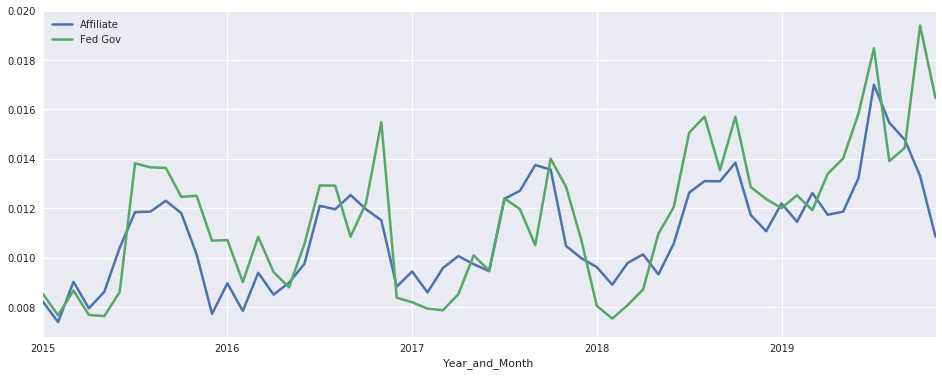

In [51]:
Channel.set_index('Year_and_Month')[['Affiliate','Fed Gov']].plot(figsize=(16, 6), linewidth=2.5)
plt.show()

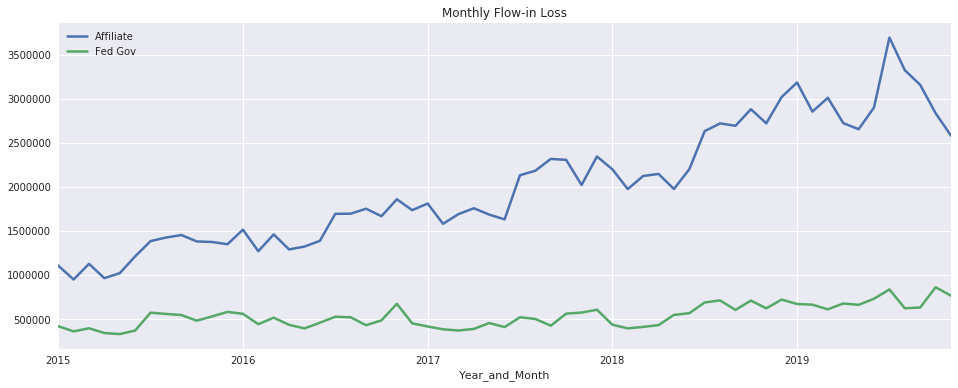

In [56]:
A.set_index('Year_and_Month')[['Affiliate','Fed Gov']].plot(title='Monthly Flow-in Loss',figsize=(16, 6), linewidth=2.5)
plt.show()

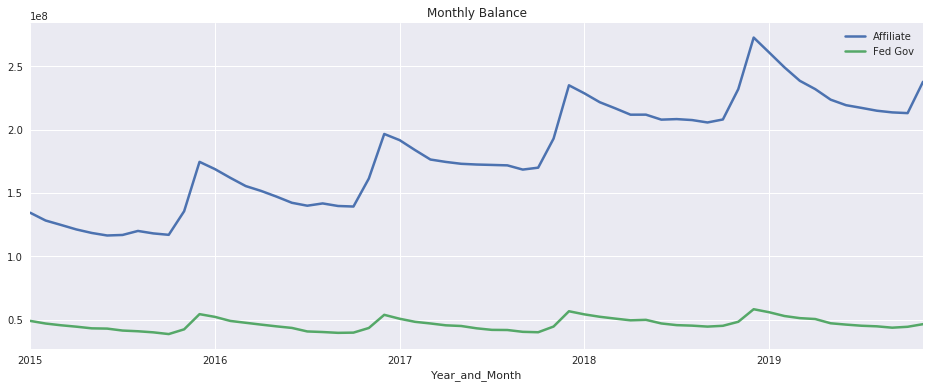

In [55]:
B.set_index('Year_and_Month')[['Affiliate','Fed Gov']].plot(title='Monthly Balance',figsize=(16, 6), linewidth=2.5)
plt.show()

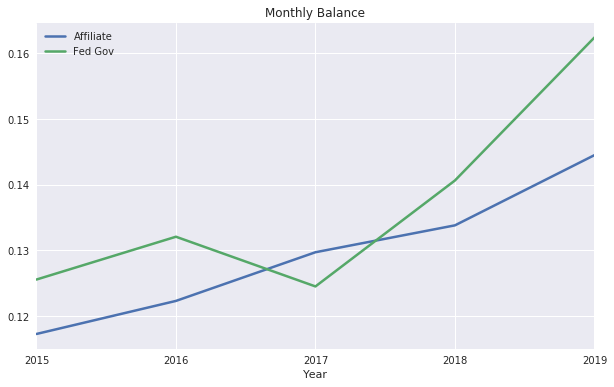

In [74]:
Channel.groupby(['Year']).agg({'Fed Gov':'sum','Affiliate':'sum'})[['Affiliate','Fed Gov']].plot(title='Monthly Balance',figsize=(10, 6), linewidth=2.5)
plt.show()

In [30]:
# Orders per Customer
Bad_Orders_p_cust = P15[(P15['Bad']==1)&(P15['Ever_Bad']==1)].groupby('Year').agg({'Unique_Customer_ID':'nunique','Unique_Order_ID':'nunique'}).reset_index()
Bad_Orders_p_cust['num_of_orders_per_cust'] = Bad_Orders_p_cust['Unique_Order_ID']/Bad_Orders_p_cust['Unique_Customer_ID']
Bad_Orders_p_cust['Year'] = pd.to_datetime(Bad_Orders_p_cust['Year'].astype(str),format='%Y')

In [35]:
Bad_Orders_p_cust

,Year,Unique_Customer_ID,Unique_Order_ID,num_of_orders_per_cust
0,2015-01-01,19132,35978,1.880514
1,2016-01-01,22263,48784,2.191259
2,2017-01-01,26688,62995,2.360424
3,2018-01-01,31779,80360,2.528714
4,2019-01-01,33886,97880,2.888509


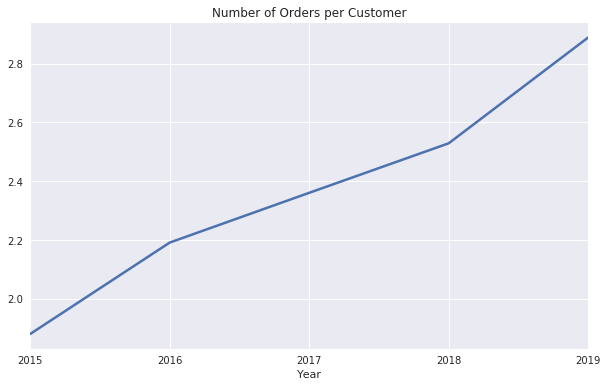

In [36]:
Bad_Orders_p_cust.set_index('Year')['num_of_orders_per_cust'].plot(title='Number of Orders per Customer',figsize=(10, 6), linewidth=2.5)
plt.show()

In [ ]:
P15[P15['Year_and_Month']=='2015-01-01'].groupby('Unique_Order_ID').filter(lambda x: x['Ever_Bad'].max()==0).shape[0] + P15[([P15['Year_and_Month']=='2015-01-01'])&(P15['Bad']==1)&(P15['Ever_Bad']==1)].shape[0]

In [15]:
P15[P15['Year_and_Month']=='2015-01-01'].shape[0]

316919

In [ ]:
# Unit Loss Rate

In [11]:
A_unit = P15[(P15['Bad']==1)&(P15['Ever_Bad']==1)].pivot_table(values = 'Unique_Order_ID',index = 'Year_and_Month', columns='Affiliate/Fed Gov?',aggfunc='nunique' ).reset_index().rename_axis(None, axis=1)

In [12]:
B_unit = P15.pivot_table(values = 'Unique_Order_ID',index = 'Year_and_Month', columns='Affiliate/Fed Gov?',aggfunc='nunique' ).reset_index().rename_axis(None, axis=1)

In [16]:
Channel_unit = A_unit.iloc[:,1:]/B_unit.iloc[:,1:]
Channel_unit['Year_and_Month'] = A_unit['Year_and_Month']
Channel_unit['Year'] = Channel_unit['Year_and_Month'].dt.year
Channel_unit['Year'] = pd.to_datetime(Channel_unit['Year'].astype(str),format='%Y')
Channel_unit

,Affiliate,Fed Gov,Year_and_Month,Year
0,0.009877,0.009729,2015-01-01,2015-01-01
1,0.008995,0.008705,2015-02-01,2015-01-01
2,0.009951,0.008546,2015-03-01,2015-01-01
3,0.008936,0.007634,2015-04-01,2015-01-01
4,0.008506,0.007313,2015-05-01,2015-01-01
5,0.008577,0.007024,2015-06-01,2015-01-01
6,0.009369,0.009625,2015-07-01,2015-01-01
7,0.009971,0.008941,2015-08-01,2015-01-01
8,0.010331,0.009414,2015-09-01,2015-01-01
9,0.009889,0.008851,2015-10-01,2015-01-01


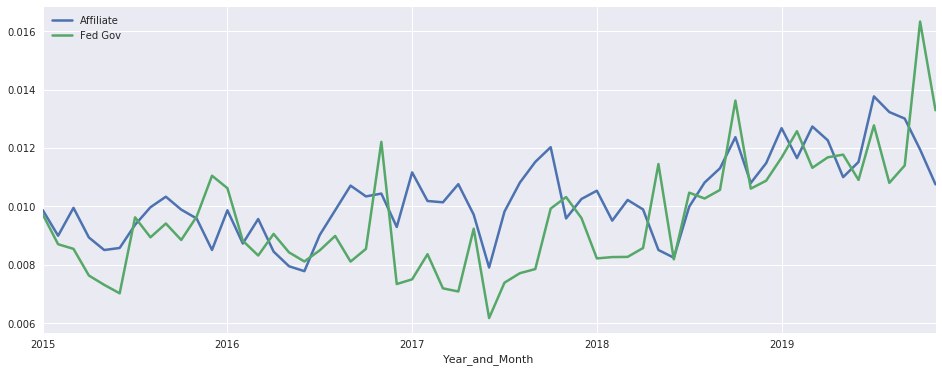

In [17]:
Channel_unit.set_index('Year_and_Month')[['Affiliate','Fed Gov']].plot(figsize=(16, 6), linewidth=2.5)
plt.show()

In [13]:
Old_2015 = Perf[(Perf['Year_and_Month']>='2014-12-01') & (Perf['Year_and_Month']<='2015-11-01')]
New_2019 = Perf[(Perf['Year_and_Month']>='2018-12-01') & (Perf['Year_and_Month']<='2019-11-01')]

In [14]:
Old_2015['Flag'] = 'Old'
New_2019['Flag'] = 'New'
df = Old_2015.append(New_2019,ignore_index = True)

In [41]:
# Loss rate by Channel
Old_lr = Old_2015[(Old_2015['Bad']==1) & (Old_2015['Ever_Bad']==1)]['2os_loss'].sum()/Old_2015['Current_Balance'].sum()*12
New_lr = New_2019[(New_2019['Bad']==1) & (New_2019['Ever_Bad']==1)]['2os_loss'].sum()/New_2019['Current_Balance'].sum()*12
print('2015 Loss Rate {}'.format(Old_lr))
print('2019 Loss Rate {}'.format(New_lr))

2015 Loss Rate 0.11300565278586913
2019 Loss Rate 0.15729958806109115


In [54]:
df[(df['Bad']==1)&(df['Ever_Bad']==1)].pivot_table(values = '2os_loss',index = 'Affiliate/Fed Gov?',columns='Flag',aggfunc='sum').rename_axis(None,axis=1).reset_index()

,Affiliate/Fed Gov?,New,Old
0,Affiliate,35934490.75,14633864.49
1,Fed Gov,8448989.94,5418059.08


In [52]:
df.pivot_table(values = 'Current_Balance',index = 'Affiliate/Fed Gov?',columns='Flag',aggfunc='sum').rename_axis(None,axis=1).reset_index()

,Affiliate/Fed Gov?,New,Old
0,Affiliate,2.793072e+09,1.490401e+09
1,Fed Gov,5.866059e+08,5.271890e+08


In [43]:
# Old_2015[(Old_2015['Bad']==1) & (Old_2015['Ever_Bad']==1)].groupby('Affiliate/Fed Gov?').agg({'2os_loss':'sum'})

,2os_loss
Affiliate/Fed Gov?,
Affiliate,14633864.49
Fed Gov,5418059.08


In [63]:
# Loss rate by Industry
loss_Ind = df[(df['Bad']==1)&(df['Ever_Bad']==1)].pivot_table(values = '2os_loss',index = 'Industry',columns='Flag',aggfunc='sum').rename_axis(None,axis=1).reset_index()#.fillna(0)
# loss_Ind.rename(columns={'New'})

prefix = 'loss_'
new_names = [(i,prefix + i) for i in ['New','Old']]
loss_Ind.rename(columns = dict(new_names), inplace=True)
loss_Ind

,Industry,loss_New,loss_Old
0,Accommodation and Food Services,1884986.18,252588.87
1,Administrative and Support,688263.07,229397.90
2,"Arts, Entertainment, and Recreation",14519.90,NaN
3,Construction,7836.01,NaN
4,Educational Services,456467.73,215692.45
5,Federal Government/Associations,8448989.94,5418059.08
6,Finance and Insurance,1140680.29,628858.93
7,Health Care and Social Assistance,11059271.43,4158014.42
8,Information,3563246.22,1378838.90
9,Local Government/Associations,797014.24,181906.19


In [62]:
bal_Ind = df.pivot_table(values = 'Current_Balance',index = 'Industry',columns='Flag',aggfunc='sum').rename_axis(None,axis=1).reset_index()#.fillna(0)

prefix = 'Balance_'
new_names = [(i,prefix + i) for i in ['New','Old']]
bal_Ind.rename(columns = dict(new_names), inplace=True)
bal_Ind

,Industry,Balance_New,Balance_Old
0,Accommodation and Food Services,1.275671e+08,1.720143e+07
1,Administrative and Support,4.208072e+07,1.641455e+07
2,"Arts, Entertainment, and Recreation",2.764343e+05,NaN
3,Construction,5.435360e+05,NaN
4,Educational Services,6.650985e+07,1.929554e+07
5,Engineering,5.713768e+04,1.825912e+04
6,Federal Government/Associations,5.866059e+08,5.271890e+08
7,Finance and Insurance,9.397760e+07,5.502826e+07
8,Health Care and Social Assistance,9.377450e+08,4.286868e+08
9,Healthcare,5.554429e+05,NaN


In [64]:
Ind = bal_Ind.merge(loss_Ind, how='left',on='Industry')#.fillna(0)
Ind

,Industry,Balance_New,Balance_Old,loss_New,loss_Old
0,Accommodation and Food Services,1.275671e+08,1.720143e+07,1884986.18,252588.87
1,Administrative and Support,4.208072e+07,1.641455e+07,688263.07,229397.90
2,"Arts, Entertainment, and Recreation",2.764343e+05,NaN,14519.90,NaN
3,Construction,5.435360e+05,NaN,7836.01,NaN
4,Educational Services,6.650985e+07,1.929554e+07,456467.73,215692.45
5,Engineering,5.713768e+04,1.825912e+04,NaN,NaN
6,Federal Government/Associations,5.866059e+08,5.271890e+08,8448989.94,5418059.08
7,Finance and Insurance,9.397760e+07,5.502826e+07,1140680.29,628858.93
8,Health Care and Social Assistance,9.377450e+08,4.286868e+08,11059271.43,4158014.42
9,Healthcare,5.554429e+05,NaN,NaN,NaN


In [14]:
Client.head()

,Active,Client ID,Account Name,Current Eligibles,Eligibles at time of Launch,Industry,NAICS Code,NAICS Description,Broker,Launch Date,Termination Date,Affiliate/Fed Gov?,CLIENT CODE,CLIENT NAME,CLIENT AR,Cash,TPA
0,Y,4270,ATLANTIC GENERAL HOSPITAL,418.0,418.0,Health Care and Social Assistance,622110.0,General Medical and Surgical Hospitals,Maryland Hospital Association/PRIME,2006-03-01,NaT,Affiliate,NaN,NaN,NaN,NaN,NaN
1,Y,1000,SOCIAL SECURITY ADMINISTRATION,60000.0,70000.0,Federal Government/Associations,923130.0,"Administration of Social, Human Resource and I...",PPC,2002-07-01,NaT,Fed Gov,SSA,SOCIAL SECURITY ADMINISTRATION,KELLY MENCHINGER,TPA sends cash on behalf of client,EAA
2,Y,3900,"STEPHENS, INC",1000.0,1000.0,Finance and Insurance,523110.0,Investment Banking and Securities Dealing,PPC,2002-02-01,NaT,Affiliate,NaN,NaN,NaN,NaN,NaN
3,Y,2458,FEDERAL MANAGERS ASSOCIATION,200000.0,200000.0,Federal Government/Associations,813920.0,Professional Organizations,NaN,2016-08-22,NaT,Fed Gov,NaN,NaN,NaN,NaN,NaN
4,Y,5006,INDIANA STATE EMPLOYEES ASSOCIATION - ACH,20000.0,20000.0,State Government/Associations,813910.0,Business Associations,PPC,2013-08-05,NaT,Affiliate,NaN,NaN,NaN,NaN,NaN


In [18]:
df_act = df[df['Active']=='Y']

In [19]:
# Loss rate by Client
loss_Cli = df_act[(df_act['Bad']==1)&(df_act['Ever_Bad']==1)].pivot_table(values = '2os_loss',index = 'Account Name',columns='Flag',aggfunc='sum').rename_axis(None,axis=1).reset_index().fillna(0)
prefix = 'loss_'
new_names = [(i,prefix + i) for i in ['New','Old']]
loss_Cli.rename(columns = dict(new_names), inplace=True)

bal_Cli = df_act.pivot_table(values = 'Current_Balance',index = 'Account Name',columns='Flag',aggfunc='sum').rename_axis(None,axis=1).reset_index()
prefix = 'Balance_'
new_names = [(i,prefix + i) for i in ['New','Old']]
bal_Cli.rename(columns = dict(new_names), inplace=True)


In [20]:
Cli = bal_Cli.merge(loss_Cli, how='left',on='Account Name').fillna(0)
Cli.to_csv('../data/Cli.csv',index = False)
Cli

,Account Name,Balance_New,Balance_Old,loss_New,loss_Old
0,"7-ELEVEN, INC.",1.253553e+05,5.667191e+05,3678.88,7756.68
1,"ADTRAN, INC.",3.107609e+05,0.000000e+00,0.00,0.00
2,"ADVANCE AUTO PARTS, INC.",3.449564e+07,2.104372e+07,598821.72,259507.97
3,AECOM,8.146848e+06,4.089357e+06,121018.58,64085.14
4,AFNI,1.318722e+06,1.543764e+06,23605.09,32417.95
5,ALABAMA STATE EMPLOYEES ASSOCIATION,6.616936e+06,6.495919e+06,54252.45,46035.00
6,ALLINA HOSPITALS & CLINICS,8.433181e+06,7.210633e+06,114680.40,59443.93
7,"ALPHASTAFF, INC.",1.849675e+06,1.238750e+06,52454.26,20796.22
8,AMERICAN FEDERATION OF GOVERNMENT EMPLOYEES,5.950113e+07,7.073871e+07,581497.87,590660.49
9,AMERICAN RED CROSS,1.962418e+07,1.603416e+07,224478.18,176283.20


In [ ]:
df[var+'_bin'] = pd.qcut(df[var], q=4)
df.groupby(var+'_bin')['Bad'].sum().div(df.groupby(var+'_bin')['Unique_Customer_ID'].size())

In [ ]:
'Customer_Salary','Customer_Tenure'

In [21]:
Customer.head()

,Unique_Customer_ID,Unique_Company_ID,Enrollment_Date,Assigned_Spending_Limit,Customer_Tenure,Customer_Salary,Prior_Customer_Flag,Street1,Street2,City,State,Zip,Status,Term_Date,Active,Client ID,Account Name,Current Eligibles,Eligibles at time of Launch,Industry,NAICS Code,NAICS Description,Broker,Launch Date,Termination Date,Affiliate/Fed Gov?,CLIENT CODE,CLIENT NAME,CLIENT AR,Cash,TPA
0,100001115,1000,2014-02-24,6880.0,230.0,58229.0,Repeat Buyer,1471 N EAST ST,NaN,YORK,PA,17406,EMPLOYED,NaT,Y,1000.0,SOCIAL SECURITY ADMINISTRATION,60000.0,70000.0,Federal Government/Associations,923130.0,"Administration of Social, Human Resource and I...",PPC,2002-07-01,NaT,Fed Gov,SSA,SOCIAL SECURITY ADMINISTRATION,KELLY MENCHINGER,TPA sends cash on behalf of client,EAA
1,100001120,1000,2014-02-24,6520.0,362.0,109245.0,Repeat Buyer,94 BRENTWOOD LN,NaN,VALLEY STREAM,NY,11581,EMPLOYED,NaT,Y,1000.0,SOCIAL SECURITY ADMINISTRATION,60000.0,70000.0,Federal Government/Associations,923130.0,"Administration of Social, Human Resource and I...",PPC,2002-07-01,NaT,Fed Gov,SSA,SOCIAL SECURITY ADMINISTRATION,KELLY MENCHINGER,TPA sends cash on behalf of client,EAA
2,100001141,1000,2014-02-25,10290.0,337.0,127226.0,Repeat Buyer,103 KENILWORTH PARK DR,APT 2B,TOWSON,MD,21204,EMPLOYED,NaT,Y,1000.0,SOCIAL SECURITY ADMINISTRATION,60000.0,70000.0,Federal Government/Associations,923130.0,"Administration of Social, Human Resource and I...",PPC,2002-07-01,NaT,Fed Gov,SSA,SOCIAL SECURITY ADMINISTRATION,KELLY MENCHINGER,TPA sends cash on behalf of client,EAA
3,100001158,1000,2014-02-24,5190.0,419.0,49375.0,Repeat Buyer,1036 BRADDISH AVE,NaN,BALTIMORE,MD,21216,EMPLOYED,NaT,Y,1000.0,SOCIAL SECURITY ADMINISTRATION,60000.0,70000.0,Federal Government/Associations,923130.0,"Administration of Social, Human Resource and I...",PPC,2002-07-01,NaT,Fed Gov,SSA,SOCIAL SECURITY ADMINISTRATION,KELLY MENCHINGER,TPA sends cash on behalf of client,EAA
4,100001169,1000,2014-02-24,7500.0,448.0,69460.0,Repeat Buyer,3915 W ROGERS AVE,NaN,BALTIMORE,MD,21215,EMPLOYED,NaT,Y,1000.0,SOCIAL SECURITY ADMINISTRATION,60000.0,70000.0,Federal Government/Associations,923130.0,"Administration of Social, Human Resource and I...",PPC,2002-07-01,NaT,Fed Gov,SSA,SOCIAL SECURITY ADMINISTRATION,KELLY MENCHINGER,TPA sends cash on behalf of client,EAA


In [27]:
def Perf_filter(df):
    """
    This function takes the Perf dataset and subgroup is with time window condition, 
    then it generates some of the customer-level variables that we expect, such as
    Num_of_Contracts,Total_CO_Balance,Total_Spend
    
    The output would be a customer-level dataframe, where the customers are enrolled in 2017-04 to 2018-04 time period
    """
    
    
    # Get the latest order records
    df = df.loc[df.groupby('Unique_Order_ID')[
        'Year_and_Month'].idxmax()]
    # create customer level data with "# of orders" and "Bad Flag"
    df = df.groupby('Unique_Customer_ID').agg(
        {'Unique_Order_ID': 'count', 'Ever_Bad': 'sum', '2os_loss': 'sum', 'Order_Amount': 'sum','Customer_Salary':'unique','Customer_Tenure':'unique'}).reset_index()
    # The definition of Bad here is whether a customer has at least 1 order goes bad
    df['Bad'] = df['Ever_Bad'] >= 1

    df.rename(columns={'Unique_Order_ID': 'Num_of_Contracts',
                           '2os_loss': 'Total_CO_Balance', 'Order_Amount': 'Total_Spend'}, inplace=True)

    return df

In [111]:
Old_2015 = Perf[(Perf['Year_and_Month']>='2014-12-01') & (Perf['Year_and_Month']<='2015-11-01')]
New_2019 = Perf[(Perf['Year_and_Month']>='2018-12-01') & (Perf['Year_and_Month']<='2019-11-01')]

In [28]:
df_2015 = Perf_filter(Old_2015)
df_2019 = Perf_filter(New_2019)

In [120]:
var = 'Customer_Salary'
cut_labels = ['[0-30000]', '[30000-40000]', '[40000-50000]', '[50000-70000]','[70000+]']
cut_bins = [0,30000, 40000, 50000, 70000,np.inf]
Old_2015[var+'_bin'] = pd.cut(Old_2015[var], bins=cut_bins, labels=cut_labels)

In [121]:
Old_2015.groupby('Customer_Salary_bin').agg({'Current_Balance':'sum'})

,Current_Balance
Customer_Salary_bin,
[0-30000],2.539928e+08
[30000-40000],3.728829e+08
[40000-50000],3.637533e+08
[50000-70000],4.742459e+08
[70000+],4.049877e+08


In [123]:
Old_2015[(Old_2015['Bad']==1)&(Old_2015['Ever_Bad']==1)].groupby('Customer_Salary_bin').agg({'2os_loss':'sum'})

,2os_loss
Customer_Salary_bin,
[0-30000],5543467.07
[30000-40000],5180025.24
[40000-50000],3165571.79
[50000-70000],3502406.68
[70000+],1772525.53


In [122]:
New_2019[var+'_bin'] = pd.cut(New_2019[var], bins=cut_bins, labels=cut_labels)
New_2019.groupby('Customer_Salary_bin').agg({'Current_Balance':'sum'})

,Current_Balance
Customer_Salary_bin,
[0-30000],3.828590e+08
[30000-40000],8.947077e+08
[40000-50000],7.211130e+08
[50000-70000],7.574033e+08
[70000+],5.619169e+08


In [124]:
New_2019[(New_2019['Bad']==1)&(New_2019['Ever_Bad']==1)].groupby('Customer_Salary_bin').agg({'2os_loss':'sum'})

,2os_loss
Customer_Salary_bin,
[0-30000],8107168.94
[30000-40000],15008228.50
[40000-50000],8730906.12
[50000-70000],8082531.34
[70000+],3840495.69


In [33]:
df_2015.head()

,Unique_Customer_ID,Num_of_Contracts,Ever_Bad,Total_CO_Balance,Total_Spend,Customer_Salary,Customer_Tenure,Bad
0,100001115,1,2,658.76,691.12,58229.0,230.0,True
1,100001120,9,0,0.00,20441.43,109245.0,362.0,False
2,100001141,1,0,0.00,2929.90,127226.0,337.0,False
3,100001158,2,11,1167.15,2603.95,49375.0,419.0,True
4,100001169,1,0,0.00,943.18,69460.0,448.0,False


In [32]:
df_2015['Customer_Salary'] = df_2015['Customer_Salary'].apply(lambda x:x[0])
df_2015['Customer_Tenure'] = df_2015['Customer_Tenure'].apply(lambda x:x[0])
df_2019['Customer_Salary'] = df_2019['Customer_Salary'].apply(lambda x:x[0])
df_2019['Customer_Tenure'] = df_2019['Customer_Tenure'].apply(lambda x:x[0])

In [38]:
df_2015['Customer_Salary'].describe()

count    1.934760e+05
mean     4.857720e+04
std      1.146223e+05
min      0.000000e+00
25%      3.120000e+04
50%      4.218000e+04
75%      5.847835e+04
max      2.610239e+07
Name: Customer_Salary, dtype: float64

In [57]:
cut_labels = ['[0-30000]', '[30000-40000]', '[40000-50000]', '[50000-70000]','[70000+]']
cut_bins = [0,30000, 40000, 50000, 70000,np.inf]
df_2015[var+'_bin'] = pd.cut(df_2015[var], bins=cut_bins, labels=cut_labels)

In [58]:
df_2015.head()

,Unique_Customer_ID,Num_of_Contracts,Ever_Bad,Total_CO_Balance,Total_Spend,Customer_Salary,Customer_Tenure,Bad,Customer_Salary_bin
0,100001115,1,2,658.76,691.12,58229.0,230.0,True,[50000-70000]
1,100001120,9,0,0.00,20441.43,109245.0,362.0,False,[70000+]
2,100001141,1,0,0.00,2929.90,127226.0,337.0,False,[70000+]
3,100001158,2,11,1167.15,2603.95,49375.0,419.0,True,[40000-50000]
4,100001169,1,0,0.00,943.18,69460.0,448.0,False,[50000-70000]


In [59]:
df_2015.groupby(var+'_bin')['Bad'].sum().div(df_2015.groupby(var+'_bin')['Unique_Customer_ID'].size())

Customer_Salary_bin
[0-30000]        0.206039
[30000-40000]    0.123328
[40000-50000]    0.085087
[50000-70000]    0.070444
[70000+]         0.045433
dtype: float64

In [60]:
df_2015.groupby(var+'_bin')['Unique_Customer_ID'].size()

Customer_Salary_bin
[0-30000]        43249
[30000-40000]    44783
[40000-50000]    35693
[50000-70000]    40259
[70000+]         29208
Name: Unique_Customer_ID, dtype: int64

In [62]:
df_2019[var+'_bin'] = pd.cut(df_2019[var], bins=cut_bins, labels=cut_labels)
df_2019.groupby(var+'_bin')['Bad'].sum().div(df_2019.groupby(var+'_bin')['Unique_Customer_ID'].size())

Customer_Salary_bin
[0-30000]        0.242111
[30000-40000]    0.163648
[40000-50000]    0.116096
[50000-70000]    0.099500
[70000+]         0.066240
dtype: float64

In [63]:
df_2019.groupby(var+'_bin')['Unique_Customer_ID'].size()

Customer_Salary_bin
[0-30000]        67754
[30000-40000]    97545
[40000-50000]    61182
[50000-70000]    57849
[70000+]         37847
Name: Unique_Customer_ID, dtype: int64

In [64]:
# Tenure
df_2015['Customer_Tenure'].describe()

count    229524.000000
mean        159.078489
std          89.743338
min         -12.000000
25%          92.000000
50%         137.000000
75%         201.000000
max        1605.000000
Name: Customer_Tenure, dtype: float64

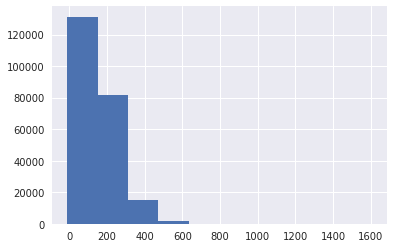

In [66]:
df_2015['Customer_Tenure'].hist(bins=10)

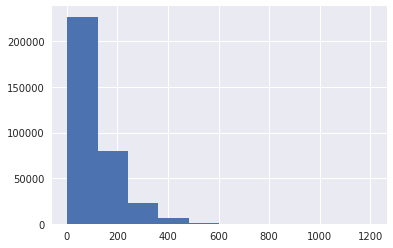

In [67]:
df_2019['Customer_Tenure'].hist(bins=10)

In [136]:
var='Customer_Tenure'
tenure_cut_labels = ['[0-50]','[50-100]', '[100-150]', '[150-200]', '[200-300]','[300+]']
tenure_cut_bins = [0,50,100,150, 200, 300,np.inf]
df_2015[var+'_bin'] = pd.cut(df_2015[var], bins=tenure_cut_bins, labels=tenure_cut_labels)
df_2015.groupby('Customer_Tenure_bin').size()

Customer_Tenure_bin
[0-50]        2118
[50-100]     69205
[100-150]    61243
[150-200]    39500
[200-300]    38725
[300+]       18732
dtype: int64

In [137]:
df_2019[var+'_bin'] = pd.cut(df_2019[var], bins=tenure_cut_bins, labels=tenure_cut_labels)
df_2019.groupby('Customer_Tenure_bin').size()

Customer_Tenure_bin
[0-50]       111789
[50-100]      95096
[100-150]     47903
[150-200]     33707
[200-300]     33686
[300+]        14461
dtype: int64

In [138]:
var='Customer_Tenure'
tenure_cut_labels = ['[0-50]','[50-100]', '[100-150]', '[150-200]', '[200-300]','[300+]']
tenure_cut_bins = [0,50,100,150, 200, 300,np.inf]
Old_2015[var+'_bin'] = pd.cut(Old_2015[var], bins=tenure_cut_bins, labels=tenure_cut_labels)
Old_2015.groupby('Customer_Tenure_bin').agg({'Current_Balance':'sum'})

,Current_Balance
Customer_Tenure_bin,
[0-50],1.768925e+07
[50-100],5.040637e+08
[100-150],5.820938e+08
[150-200],4.059568e+08
[200-300],4.244169e+08
[300+],2.126137e+08


In [139]:
Old_2015[(Old_2015['Bad']==1)&(Old_2015['Ever_Bad']==1)].groupby('Customer_Tenure_bin').agg({'2os_loss':'sum'})

,2os_loss
Customer_Tenure_bin,
[0-50],180966.57
[50-100],6566482.34
[100-150],6497213.28
[150-200],3221683.86
[200-300],2675648.92
[300+],1075890.25


In [140]:
New_2019[var+'_bin'] = pd.cut(New_2019[var], bins=tenure_cut_bins, labels=tenure_cut_labels)
New_2019.groupby('Customer_Tenure_bin').agg({'Current_Balance':'sum'})

,Current_Balance
Customer_Tenure_bin,
[0-50],8.793964e+08
[50-100],9.795954e+08
[100-150],5.520907e+08
[150-200],4.020767e+08
[200-300],4.062045e+08
[300+],1.702520e+08


In [141]:
New_2019[(New_2019['Bad']==1)&(New_2019['Ever_Bad']==1)].groupby('Customer_Tenure_bin').agg({'2os_loss':'sum'})

,2os_loss
Customer_Tenure_bin,
[0-50],16131531.12
[50-100],15109857.83
[100-150],5875263.22
[150-200],3295217.62
[200-300],2753509.79
[300+],1265676.90


In [142]:
180966.57/1.768925e+07

0.010230313325890018

In [143]:
6566482.34/5.040637e+08

0.01302708832236878

In [144]:
16131531.12/8.793964e+08

0.018343867589178213

In [145]:
15109857.83/9.795954e+08

0.015424590427843986

In [80]:
df_2015.groupby(var+'_bin')['Bad'].sum().div(df_2015.groupby(var+'_bin')['Unique_Customer_ID'].size())

Customer_Tenure_bin
[0-100]      0.115615
[100-150]    0.120422
[150-200]    0.087924
[200-300]    0.070187
[300+]       0.060858
dtype: float64

In [77]:
df_2015.groupby(var+'_bin')['Unique_Customer_ID'].size()

Customer_Tenure_bin
[0-50]       71323
[100-150]    61243
[150-200]    39500
[200-300]    38725
[300+]       18732
Name: Unique_Customer_ID, dtype: int64

In [83]:
df_2019[var+'_bin'] = pd.cut(df_2019[var], bins=tenure_cut_bins, labels=tenure_cut_labels)
df_2019.groupby(var+'_bin')['Bad'].sum().div(df_2019.groupby(var+'_bin')['Unique_Customer_ID'].size())

Customer_Tenure_bin
[0-100]      0.176344
[100-150]    0.119283
[150-200]    0.093957
[200-300]    0.075105
[300+]       0.077242
dtype: float64

In [84]:
df_2019.groupby(var+'_bin')['Unique_Customer_ID'].size()

Customer_Tenure_bin
[0-100]      206885
[100-150]     47903
[150-200]     33707
[200-300]     33686
[300+]        14461
Name: Unique_Customer_ID, dtype: int64

In [85]:
df_2015['Flag'] = 'Old'
df_2019['Flag'] = 'New'
df_cust = df_2015.append(df_2019,ignore_index = True)

In [86]:
df_cust.head()

,Unique_Customer_ID,Num_of_Contracts,Ever_Bad,Total_CO_Balance,Total_Spend,Customer_Salary,Customer_Tenure,Bad,Customer_Salary_bin,Customer_Tenure_bin,Flag
0,100001115,1,2,658.76,691.12,58229.0,230.0,True,[50000-70000],[200-300],Old
1,100001120,9,0,0.00,20441.43,109245.0,362.0,False,[70000+],[300+],Old
2,100001141,1,0,0.00,2929.90,127226.0,337.0,False,[70000+],[300+],Old
3,100001158,2,11,1167.15,2603.95,49375.0,419.0,True,[40000-50000],[300+],Old
4,100001169,1,0,0.00,943.18,69460.0,448.0,False,[50000-70000],[300+],Old


In [135]:
df_cust['Customer_Tenure_bin'].value_counts(dropna=False)

[0-100]      278208
[100-150]    109146
[150-200]     73207
[200-300]     72411
[300+]        33193
NaN              67
Name: Customer_Tenure_bin, dtype: int64

In [96]:
df_cust[df_cust['Customer_Salary_bin'].isnull()]

,Unique_Customer_ID,Num_of_Contracts,Ever_Bad,Total_CO_Balance,Total_Spend,Customer_Salary,Customer_Tenure,Bad,Customer_Salary_bin,Customer_Tenure_bin,Flag
10,100001216,2,5,3916.97,8109.75,NaN,353.0,True,NaN,[300+],Old
30,100003338,1,0,0.00,1348.89,NaN,613.0,False,NaN,[300+],Old
42,100003572,1,0,0.00,4996.96,NaN,290.0,False,NaN,[200-300],Old
44,100003591,1,0,0.00,620.93,NaN,541.0,False,NaN,[300+],Old
118,100008296,4,58,0.00,6071.95,NaN,480.0,True,NaN,[300+],Old
119,100008309,2,0,0.00,2342.47,NaN,223.0,False,NaN,[200-300],Old
148,100008882,8,0,0.00,6807.05,NaN,508.0,False,NaN,[300+],Old
149,100008884,5,35,1483.70,6968.42,NaN,449.0,True,NaN,[300+],Old
168,100011996,1,0,0.00,2790.55,NaN,224.0,False,NaN,[200-300],Old
174,100013354,9,0,0.00,13064.43,NaN,373.0,False,NaN,[300+],Old


In [104]:
df_cust[df_cust['Customer_Salary_bin'].notnull()].pivot_table(index='Customer_Salary_bin', values=
                    ['Total_CO_Balance','Total_Spend'], columns='Flag', aggfunc='sum')  # .reset_index()

Total_CO_Balance               Total_Spend              
Flag                             New         Old           New           Old
Customer_Salary_bin                                                         
[0-30000]                10541381.20  6202080.61  1.168834e+08  7.215053e+07
[30000-40000]            18653021.34  5828292.94  2.715251e+08  1.080915e+08
[40000-50000]            10748157.11  3623792.59  2.230013e+08  1.064902e+08
[50000-70000]             9752073.24  3981159.96  2.386574e+08  1.403800e+08
[70000+]                  4620304.07  2018301.45  1.813145e+08  1.225013e+08

In [106]:
df_cust[df_cust['Customer_Salary_bin'].notnull()].pivot_table(index='Customer_Salary_bin', values=
                    'Unique_Customer_ID', columns='Flag', aggfunc='nunique')  # .reset_index()

Flag,New,Old
Customer_Salary_bin,,
[0-30000],67754,43249
[30000-40000],97545,44783
[40000-50000],61182,35693
[50000-70000],57849,40259
[70000+],37847,29208


In [107]:
df_cust[df_cust['Customer_Tenure_bin'].notnull()].pivot_table(index='Customer_Tenure_bin', values=
                    ['Total_CO_Balance','Total_Spend'], columns='Flag', aggfunc='sum')  # .reset_index()

Total_CO_Balance               Total_Spend              
Flag                             New         Old           New           Old
Customer_Tenure_bin                                                         
[0-100]                  38241257.28  7256936.82  5.632949e+08  1.425728e+08
[100-150]                 7527824.58  7446807.02  1.770464e+08  1.728487e+08
[150-200]                 4268450.69  3701912.72  1.300171e+08  1.221476e+08
[200-300]                 3524689.68  3061671.36  1.324575e+08  1.276880e+08
[300+]                    1522649.63  1233259.73  5.538212e+07  6.454704e+07

In [108]:
df_cust[df_cust['Customer_Tenure_bin'].notnull()].pivot_table(index='Customer_Tenure_bin', values=
                    'Unique_Customer_ID', columns='Flag', aggfunc='nunique')  # .reset_index()

Flag,New,Old
Customer_Tenure_bin,,
[0-100],206885,71323
[100-150],47903,61243
[150-200],33707,39500
[200-300],33686,38725
[300+],14461,18732


In [112]:
df[['State_x','State_y']].head()

,State_x,State_y
0,CA,CA
1,CA,CA
2,CA,CA
3,CA,CA
4,CA,CA


In [117]:
sum(df['State_x']==df['State_y'])/df.shape[0]

0.9691959340485933

In [118]:
df[(df['State_x']!=df['State_y'])&(df['Bad']==1)&(df['Ever_Bad']==1)].shape[0]

4116

In [119]:
4116/394321

0.010438196291853592

In [116]:
df[df['State_x']!=df['State_y']][['State_x','State_y']]

,State_x,State_y
42,MA,VT
43,MA,VT
44,MA,VT
45,MA,VT
68,FL,NY
71,AL,MA
97,CA,FL
98,CA,FL
176,IA,IL
177,IA,IL


In [131]:
geo_loss = df[(df['State_x']==df['State_y'])&(df['Bad']==1)&(df['Ever_Bad']==1)].pivot_table(values = '2os_loss',index = 'State_x',columns='Flag',aggfunc='sum').rename_axis(None,axis=1).reset_index().fillna(0)
prefix = 'loss_'
new_names = [(i,prefix + i) for i in ['New','Old']]
geo_loss.rename(columns = dict(new_names), inplace=True)

geo_bal = df[(df['State_x']==df['State_y'])].pivot_table(values = 'Current_Balance',index = 'State_x',columns='Flag',aggfunc='sum').rename_axis(None,axis=1).reset_index().fillna(0)
prefix = 'Balance_'
new_names = [(i,prefix + i) for i in ['New','Old']]
geo_bal.rename(columns = dict(new_names), inplace=True)

In [134]:
geo = geo_bal.merge(geo_loss, how='left',on='State_x').fillna(0)
geo.to_csv('../data/geo.csv',index = False)
geo

,State_x,Balance_New,Balance_Old,loss_New,loss_Old
0,AA,6.729200e+03,0.000000e+00,0.00,0.00
1,AK,1.607674e+06,1.074569e+06,17113.65,12365.06
2,AL,8.336827e+07,4.779713e+07,1095020.73,547025.74
3,AR,3.852875e+07,3.841779e+07,539433.00,392177.87
4,AZ,9.427015e+07,8.814991e+07,1091807.96,745451.62
5,CA,3.265890e+08,2.486224e+08,3925214.65,1992408.41
6,CO,2.558142e+07,1.804901e+07,347249.52,168781.67
7,CT,1.962160e+07,7.937374e+06,199387.78,40940.63
8,DC,1.575097e+07,1.178484e+07,196433.59,127391.48
9,DE,8.190568e+06,4.894933e+06,113704.00,65248.52


In [133]:
geo_loss

,State_x,loss_New,loss_Old
0,AK,17113.65,12365.06
1,AL,1095020.73,547025.74
2,AR,539433.00,392177.87
3,AZ,1091807.96,745451.62
4,CA,3925214.65,1992408.41
5,CO,347249.52,168781.67
6,CT,199387.78,40940.63
7,DC,196433.59,127391.48
8,DE,113704.00,65248.52
9,FL,2650192.87,1156426.31


### Create `Tenure_new`  - Enrollment date to today

In [45]:
df['Tenure_new'] = (pd.to_datetime('02-01-2020') - df['Enrollment_Date'])/np.timedelta64(1, 'M')
# df['Tenure_new'] = df['Tenure_new'].fillna(-1)
# df['Tenure_new'] = df['Tenure_new'].astype(int)
# df['Tenure_new'] = df['Tenure_new'].replace('-1', np.nan)
df['Tenure_new'] = df['Tenure_new'].apply(lambda x: int(x) if (pd.notnull(x)) & (x>0) else np.nan)


In [120]:
# Customer_Tenure - (monthdiff(Nov 2019, Year_and_Month))
Old_2015['Tenure_new'] = Old_2015['Customer_Tenure']-(pd.to_datetime('11-01-2019') - Old_2015['Year_and_Month'])/np.timedelta64(1, 'M')
New_2019['Tenure_new'] = New_2019['Customer_Tenure']-(pd.to_datetime('11-01-2019') - New_2019['Year_and_Month'])/np.timedelta64(1, 'M')

In [121]:
Old_2015['Flag'] = 'Old'
New_2019['Flag'] = 'New'
df = Old_2015.append(New_2019,ignore_index = True)

In [115]:
df.head()

,Unique_Order_ID,Unique_Customer_ID,Order_Amount,Product_Markup,Payments_Due,Current_Balance,Date_account_went_delinquent,Default_Status,Delinquency_Bucket,Losses,Auto_Pay_Enrollment,Order_Closed_Flag,Type_of_Backup_Payment,Spending_Limit_at_time_of_Order,Tenure_at_time_of_Order,Salary_at_time_of_Order,Street1_x,Street2_x,City_x,State_x,Zip_x,Items_Ordered,Year_and_Month,Customer_Status,Order_Date,YQ,Year,Payment_Order,Bad,Ever_Bad,2os_loss,Unique_Company_ID,Enrollment_Date,Assigned_Spending_Limit,Customer_Tenure,Customer_Salary,Prior_Customer_Flag,Street1_y,Street2_y,City_y,State_y,Zip_y,Status,Term_Date,Active,Client ID,Account Name,Current Eligibles,Eligibles at time of Launch,Industry,NAICS Code,NAICS Description,Broker,Launch Date,Termination Date,Affiliate/Fed Gov?,CLIENT CODE,CLIENT NAME,CLIENT AR,Cash,TPA,Tenure_new
0,YCCZIMM1449606,173585108,349.57,NaN,6.72,168.00,2014-09-30,151+,151+,0.0,PD,N,ACH,31.9,146.0,28308.8,397 PARKWAY PLZ,"EL CAJON, CA",EL CAJON,CA,92020.0,The SAK Ventura Convertible Backpack Black; Ji...,2014-12-01,LOA,2014-01-17,2014Q4,2014,12.0,1,1,168.00,2309.0,2014-02-24,3190.0,146.0,28308.8,Repeat Buyer,750 SCRANTON ST,APT 8,EL CAJON,CA,92020,LOA,NaT,Terminated,2309.0,YANKEE CANDLE COMPANY,2104.0,1999.0,Manufacturing,339999.0,All Other Miscellaneous Manufacturing,"Beneplace, Inc",2012-06-15,2014-12-31,Affiliate,NaN,NaN,NaN,NaN,PAYLOGIX,98.0
1,YCCZIMM1449606,173585108,349.57,NaN,6.72,168.00,2014-09-30,151+,151+,0.0,PD,N,ACH,31.9,146.0,28308.8,397 PARKWAY PLZ,"EL CAJON, CA",EL CAJON,CA,92020.0,The SAK Ventura Convertible Backpack Black; Ji...,2015-01-01,LOA,2014-01-17,2015Q1,2015,13.0,1,2,168.00,2309.0,2014-02-24,3190.0,146.0,28308.8,Repeat Buyer,750 SCRANTON ST,APT 8,EL CAJON,CA,92020,LOA,NaT,Terminated,2309.0,YANKEE CANDLE COMPANY,2104.0,1999.0,Manufacturing,339999.0,All Other Miscellaneous Manufacturing,"Beneplace, Inc",2012-06-15,2014-12-31,Affiliate,NaN,NaN,NaN,NaN,PAYLOGIX,98.0
2,YCCZIMM1449606,173585108,349.57,NaN,6.72,168.00,2014-09-30,151+,151+,0.0,PD,N,ACH,31.9,146.0,28308.8,397 PARKWAY PLZ,"EL CAJON, CA",EL CAJON,CA,92020.0,The SAK Ventura Convertible Backpack Black; Ji...,2015-02-01,LOA,2014-01-17,2015Q1,2015,14.0,1,3,168.00,2309.0,2014-02-24,3190.0,146.0,28308.8,Repeat Buyer,750 SCRANTON ST,APT 8,EL CAJON,CA,92020,LOA,NaT,Terminated,2309.0,YANKEE CANDLE COMPANY,2104.0,1999.0,Manufacturing,339999.0,All Other Miscellaneous Manufacturing,"Beneplace, Inc",2012-06-15,2014-12-31,Affiliate,NaN,NaN,NaN,NaN,PAYLOGIX,98.0
3,YCCZIMM1449606,173585108,349.57,NaN,6.72,168.00,2014-09-30,151+,151+,0.0,PD,N,ACH,31.9,146.0,28308.8,397 PARKWAY PLZ,"EL CAJON, CA",EL CAJON,CA,92020.0,The SAK Ventura Convertible Backpack Black; Ji...,2015-03-01,LOA,2014-01-17,2015Q1,2015,15.0,1,4,168.00,2309.0,2014-02-24,3190.0,146.0,28308.8,Repeat Buyer,750 SCRANTON ST,APT 8,EL CAJON,CA,92020,LOA,NaT,Terminated,2309.0,YANKEE CANDLE COMPANY,2104.0,1999.0,Manufacturing,339999.0,All Other Miscellaneous Manufacturing,"Beneplace, Inc",2012-06-15,2014-12-31,Affiliate,NaN,NaN,NaN,NaN,PAYLOGIX,98.0
4,YCCZIMM1449606,173585108,349.57,NaN,6.72,107.52,2014-09-30,151+,151+,0.0,PD,N,ACH,31.9,146.0,28308.8,397 PARKWAY PLZ,"EL CAJON, CA",EL CAJON,CA,92020.0,The SAK Ventura Convertible Backpack Black; Ji...,2015-04-01,LOA,2014-01-17,2015Q2,2015,16.0,1,5,107.52,2309.0,2014-02-24,3190.0,146.0,28308.8,Repeat Buyer,750 SCRANTON ST,APT 8,EL CAJON,CA,92020,LOA,NaT,Terminated,2309.0,YANKEE CANDLE COMPANY,2104.0,1999.0,Manufacturing,339999.0,All Other Miscellaneous Manufacturing,"Beneplace, Inc",2012-06-15,2014-12-31,Affiliate,NaN,NaN,NaN,NaN,PAYLOGIX,98.0


In [46]:
df['Tenure_new'].describe()

count    1.280090e+07
mean     5.236298e+01
std      2.086016e+01
min      2.000000e+00
25%      3.300000e+01
50%      6.200000e+01
75%      7.100000e+01
max      7.100000e+01
Name: Tenure_new, dtype: float64

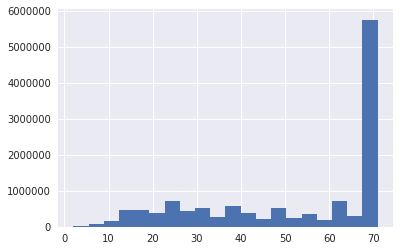

In [53]:
df['Tenure_new'].hist(bins=20)

In [54]:
Old_2015['Enrollment_Date'].describe()

count                 3995359
unique                    677
top       2014-02-24 00:00:00
freq                  1710763
first     2014-02-24 00:00:00
last      2019-06-19 00:00:00
Name: Enrollment_Date, dtype: object

In [58]:
(130175+113936)/Customer.shape[0]

0.39388433779263676

In [60]:
Customer.groupby(Customer["Enrollment_Date"].dt.month).count()

,Unique_Customer_ID,Unique_Company_ID,Enrollment_Date,Assigned_Spending_Limit,Customer_Tenure,Customer_Salary,Prior_Customer_Flag,Street1,Street2,City,State,Zip,Status,Term_Date,Active,Client ID,Account Name,Current Eligibles,Eligibles at time of Launch,Industry,NAICS Code,NAICS Description,Broker,Launch Date,Termination Date,Affiliate/Fed Gov?,CLIENT CODE,CLIENT NAME,CLIENT AR,Cash,TPA
Enrollment_Date,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
1,17825,17825,17825,17825,17820,16342,17825,17822,4214,17821,17825,17825,17823,3117,17066,17066,17066,15111,16883,17066,15121,15124,11971,16991,1057,16991,9266,9266,9266,9266,9619
2,260275,260275,260275,260275,260228,225905,260275,260243,56796,260240,260274,260274,260123,57975,249517,249517,249517,198025,247116,249517,202155,203455,165975,247276,33029,247276,106109,106109,106109,106109,119554
3,27655,27655,27655,27655,27653,24932,27655,27651,6255,27652,27655,27655,27609,4402,26284,26284,26284,23329,26035,26284,23400,23421,19007,26125,1769,26125,13417,13417,13417,13417,14280
4,24406,24406,24406,24406,24402,21797,24406,24400,5471,24400,24406,24403,24358,4032,23137,23137,23137,20357,22924,23137,20386,20416,16755,23017,1569,23017,11463,11463,11463,11463,12118
5,25534,25534,25534,25534,25532,23102,25534,25531,5619,25532,25534,25533,25502,4468,24264,24264,24264,21624,24081,24264,21698,21704,17448,24166,1607,24166,12672,12672,12672,12672,13204
6,22784,22784,22784,22784,22776,20742,22784,22782,5289,22783,22784,22784,22782,3984,21700,21700,21700,18992,21529,21700,19053,19066,15060,21588,1680,21588,11387,11387,11387,11387,11963
7,35921,35921,35921,35921,35919,32774,35921,35916,8085,35918,35921,35921,35918,5574,34205,34205,34205,31082,33976,34205,31157,31183,26295,34068,1830,34068,20285,20285,20285,20285,21060
8,30584,30584,30584,30584,30579,27941,30584,30582,6889,30582,30584,30584,30581,5078,29128,29128,29128,25919,28876,29128,25999,26013,21240,28981,1826,28978,16128,16128,16128,16128,16899
9,28623,28623,28623,28623,28613,26263,28623,28619,6567,28619,28623,28623,28622,4852,27397,27397,27397,24461,26831,27397,24507,24514,19657,27249,1790,27056,14734,14734,14734,14734,15496


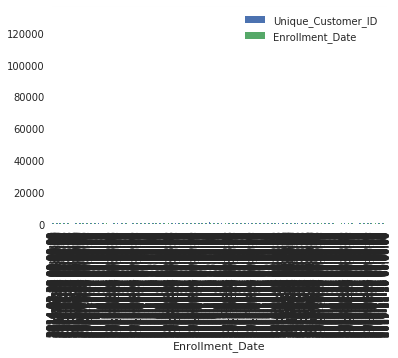

In [63]:
Customer[['Unique_Customer_ID','Enrollment_Date']].groupby(Customer["Enrollment_Date"]).count().plot(kind="bar")

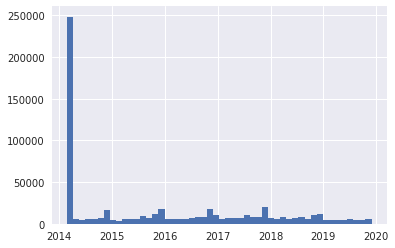

In [66]:
Customer['Enrollment_Date'].hist(bins=50)
plt.show()

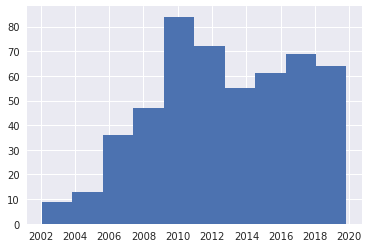

In [67]:
Client['Launch Date'].hist()

In [68]:
Customer['Y'] = Customer['Enrollment_Date'].dt.year

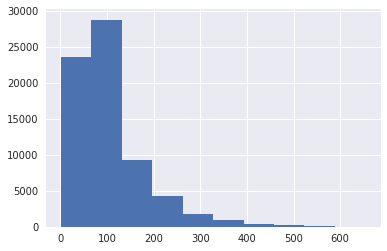

In [69]:
Customer[Customer['Y']==2015]['Customer_Tenure'].hist()

,Customer_Tenure,enroll_to_today
count,69338.000000,69347.000000
mean,108.100911,49.925303
std,74.678458,3.347325
min,1.000000,46.000000
25%,62.000000,47.000000
50%,77.000000,49.000000
75%,129.000000,52.000000
max,654.000000,57.000000


In [72]:
Customer['enroll_to_today'] = (pd.to_datetime('11-01-2019') - Customer['Enrollment_Date'])/np.timedelta64(1, 'M')
Customer['enroll_to_today'] = Customer['enroll_to_today'].apply(lambda x: int(x) if (pd.notnull(x)) & (x>0) else np.nan)

In [74]:
Customer[Customer['Y']==2015][['Customer_Tenure','enroll_to_today']].describe()

,Customer_Tenure,enroll_to_today
count,69338.000000,69347.000000
mean,108.100911,49.925303
std,74.678458,3.347325
min,1.000000,46.000000
25%,62.000000,47.000000
50%,77.000000,49.000000
75%,129.000000,52.000000
max,654.000000,57.000000


In [77]:
# Customer[Customer['Y']==2016][['Customer_Tenure','enroll_to_today']].describe()

In [78]:
# Customer[Customer['Y']==2017][['Customer_Tenure','enroll_to_today']].describe()

In [80]:
Customer[(Customer['Y']==2015)&(Customer['Customer_Tenure']<Customer['enroll_to_today'])][['Unique_Customer_ID','Customer_Tenure','enroll_to_today','Enrollment_Date']]

,Unique_Customer_ID,Customer_Tenure,enroll_to_today,Enrollment_Date
295305,300525443,54.0,57.0,2015-01-01
295324,300525516,48.0,57.0,2015-01-01
295330,300525540,20.0,57.0,2015-01-02
295346,300525581,36.0,57.0,2015-01-02
295376,300525771,43.0,57.0,2015-01-03
295394,300525871,19.0,57.0,2015-01-04
295540,300526568,39.0,57.0,2015-01-02
295573,300526664,47.0,57.0,2015-01-02
295577,300526675,21.0,57.0,2015-01-03
295594,300526777,52.0,57.0,2015-01-04


In [81]:
1186/Customer[Customer['Y']==2016].shape[0]

0.016520176623810785

In [82]:
ab_cust = Old_2015[(Old_2015['Y']==2015)&(Old_2015['Old_2015_Tenure']<Old_2015['enroll_to_today'])]['Unique_Old_2015_ID'].tolist()

In [83]:
Old_2015['enroll_to_today'] = (pd.to_datetime('11-01-2019') - Old_2015['Enrollment_Date'])/np.timedelta64(1, 'M')
Old_2015['enroll_to_today'] = Old_2015['enroll_to_today'].apply(lambda x: int(x) if (pd.notnull(x)) & (x>0) else np.nan)

In [89]:
ab_cust = Old_2015[(Old_2015['Customer_Tenure']<Old_2015['enroll_to_today'])]['Unique_Customer_ID'].unique().tolist()

In [90]:
len(ab_cust)

2968

In [91]:
Old_2015['Unique_Customer_ID'].nunique()

229568

In [92]:
New_2019[New_2019['Unique_Customer_ID'].isin(ab_cust)]['Unique_Customer_ID'].nunique()

1393

In [93]:
Old_2015.head()

,Unique_Order_ID,Unique_Customer_ID,Order_Amount,Product_Markup,Payments_Due,Current_Balance,Date_account_went_delinquent,Default_Status,Delinquency_Bucket,Losses,Auto_Pay_Enrollment,Order_Closed_Flag,Type_of_Backup_Payment,Spending_Limit_at_time_of_Order,Tenure_at_time_of_Order,Salary_at_time_of_Order,Street1_x,Street2_x,City_x,State_x,Zip_x,Items_Ordered,Year_and_Month,Customer_Status,Order_Date,YQ,Year,Payment_Order,Bad,Ever_Bad,2os_loss,Unique_Company_ID,Enrollment_Date,Assigned_Spending_Limit,Customer_Tenure,Customer_Salary,Prior_Customer_Flag,Street1_y,Street2_y,City_y,State_y,Zip_y,Status,Term_Date,Active,Client ID,Account Name,Current Eligibles,Eligibles at time of Launch,Industry,NAICS Code,NAICS Description,Broker,Launch Date,Termination Date,Affiliate/Fed Gov?,CLIENT CODE,CLIENT NAME,CLIENT AR,Cash,TPA,Flag,enroll_to_today
11,YCCZIMM1449606,173585108,349.57,NaN,6.72,168.00,2014-09-30,151+,151+,0.0,PD,N,ACH,31.9,146.0,28308.8,397 PARKWAY PLZ,"EL CAJON, CA",EL CAJON,CA,92020.0,The SAK Ventura Convertible Backpack Black; Ji...,2014-12-01,LOA,2014-01-17,2014Q4,2014,12.0,1,1,168.00,2309.0,2014-02-24,3190.0,146.0,28308.8,Repeat Buyer,750 SCRANTON ST,APT 8,EL CAJON,CA,92020,LOA,NaT,Terminated,2309.0,YANKEE CANDLE COMPANY,2104.0,1999.0,Manufacturing,339999.0,All Other Miscellaneous Manufacturing,"Beneplace, Inc",2012-06-15,2014-12-31,Affiliate,NaN,NaN,NaN,NaN,PAYLOGIX,Old,68.0
12,YCCZIMM1449606,173585108,349.57,NaN,6.72,168.00,2014-09-30,151+,151+,0.0,PD,N,ACH,31.9,146.0,28308.8,397 PARKWAY PLZ,"EL CAJON, CA",EL CAJON,CA,92020.0,The SAK Ventura Convertible Backpack Black; Ji...,2015-01-01,LOA,2014-01-17,2015Q1,2015,13.0,1,2,168.00,2309.0,2014-02-24,3190.0,146.0,28308.8,Repeat Buyer,750 SCRANTON ST,APT 8,EL CAJON,CA,92020,LOA,NaT,Terminated,2309.0,YANKEE CANDLE COMPANY,2104.0,1999.0,Manufacturing,339999.0,All Other Miscellaneous Manufacturing,"Beneplace, Inc",2012-06-15,2014-12-31,Affiliate,NaN,NaN,NaN,NaN,PAYLOGIX,Old,68.0
13,YCCZIMM1449606,173585108,349.57,NaN,6.72,168.00,2014-09-30,151+,151+,0.0,PD,N,ACH,31.9,146.0,28308.8,397 PARKWAY PLZ,"EL CAJON, CA",EL CAJON,CA,92020.0,The SAK Ventura Convertible Backpack Black; Ji...,2015-02-01,LOA,2014-01-17,2015Q1,2015,14.0,1,3,168.00,2309.0,2014-02-24,3190.0,146.0,28308.8,Repeat Buyer,750 SCRANTON ST,APT 8,EL CAJON,CA,92020,LOA,NaT,Terminated,2309.0,YANKEE CANDLE COMPANY,2104.0,1999.0,Manufacturing,339999.0,All Other Miscellaneous Manufacturing,"Beneplace, Inc",2012-06-15,2014-12-31,Affiliate,NaN,NaN,NaN,NaN,PAYLOGIX,Old,68.0
14,YCCZIMM1449606,173585108,349.57,NaN,6.72,168.00,2014-09-30,151+,151+,0.0,PD,N,ACH,31.9,146.0,28308.8,397 PARKWAY PLZ,"EL CAJON, CA",EL CAJON,CA,92020.0,The SAK Ventura Convertible Backpack Black; Ji...,2015-03-01,LOA,2014-01-17,2015Q1,2015,15.0,1,4,168.00,2309.0,2014-02-24,3190.0,146.0,28308.8,Repeat Buyer,750 SCRANTON ST,APT 8,EL CAJON,CA,92020,LOA,NaT,Terminated,2309.0,YANKEE CANDLE COMPANY,2104.0,1999.0,Manufacturing,339999.0,All Other Miscellaneous Manufacturing,"Beneplace, Inc",2012-06-15,2014-12-31,Affiliate,NaN,NaN,NaN,NaN,PAYLOGIX,Old,68.0
15,YCCZIMM1449606,173585108,349.57,NaN,6.72,107.52,2014-09-30,151+,151+,0.0,PD,N,ACH,31.9,146.0,28308.8,397 PARKWAY PLZ,"EL CAJON, CA",EL CAJON,CA,92020.0,The SAK Ventura Convertible Backpack Black; Ji...,2015-04-01,LOA,2014-01-17,2015Q2,2015,16.0,1,5,107.52,2309.0,2014-02-24,3190.0,146.0,28308.8,Repeat Buyer,750 SCRANTON ST,APT 8,EL CAJON,CA,92020,LOA,NaT,Terminated,2309.0,YANKEE CANDLE COMPANY,2104.0,1999.0,Manufacturing,339999.0,All Other Miscellaneous Manufacturing,"Beneplace, Inc",2012-06-15,2014-12-31,Affiliate,NaN,NaN,NaN,NaN,PAYLOGIX,Old,68.0


In [122]:
var='Tenure_new'
tenure_cut_labels = ['[0-50]','[50-100]', '[100-150]', '[150-200]', '[200-300]','[300+]']
tenure_cut_bins = [0,50,100,150, 200, 300,np.inf]
df[var+'_bin'] = pd.cut(df[var], bins=tenure_cut_bins, labels=tenure_cut_labels)
df.pivot_table(index ='Tenure_new_bin',values='Unique_Customer_ID',columns='Flag',aggfunc='nunique')

Flag,New,Old
Tenure_new_bin,,
[0-50],139001,79698
[50-100],100586,70469
[100-150],55307,44759
[150-200],37162,28470
[200-300],34416,21947
[300+],14221,11871


In [43]:
tenure_loss = df[(df['Bad']==1)&(df['Ever_Bad']==1)].pivot_table(values = '2os_loss',index = 'Tenure_new_bin',columns='Flag',aggfunc='sum').rename_axis(None,axis=1).reset_index()

In [125]:
tenure_loss

,Tenure_new_bin,loss_New,loss_Old
0,[0-50],18820713.11,7067828.85
1,[50-100],13218787.19,6266378.64
2,[100-150],5505012.20,3051010.22
3,[150-200],3114609.38,1741341.57
4,[200-300],2561747.19,1229692.72
5,[300+],1196914.63,653900.61


In [123]:
tenure_loss = df[(df['Bad']==1)&(df['Ever_Bad']==1)].pivot_table(values = '2os_loss',index = 'Tenure_new_bin',columns='Flag',aggfunc='sum').rename_axis(None,axis=1).reset_index()
prefix = 'loss_'
new_names = [(i,prefix + i) for i in ['New','Old']]
tenure_loss.rename(columns = dict(new_names), inplace=True)

tenure_bal = df.pivot_table(values = 'Current_Balance',index = 'Tenure_new_bin',columns='Flag',aggfunc='sum').rename_axis(None,axis=1).reset_index()
prefix = 'Balance_'
new_names = [(i,prefix + i) for i in ['New','Old']]
tenure_bal.rename(columns = dict(new_names), inplace=True)

In [126]:
tenure_bal

,Tenure_new_bin,Balance_New,Balance_Old
0,[0-50],1.033315e+09,5.470720e+08
1,[50-100],8.916135e+08,5.773589e+08
2,[100-150],5.460879e+08,3.879380e+08
3,[150-200],3.735955e+08,2.670178e+08
4,[200-300],3.848856e+08,2.216212e+08
5,[300+],1.594306e+08,1.272325e+08


In [127]:
tenure = tenure_bal.merge(tenure_loss, how='left',on='Tenure_new_bin')
tenure.to_csv('../data/tenure.csv',index = False)
tenure

,Tenure_new_bin,Balance_New,Balance_Old,loss_New,loss_Old
0,[0-50],1.033315e+09,5.470720e+08,18820713.11,7067828.85
1,[50-100],8.916135e+08,5.773589e+08,13218787.19,6266378.64
2,[100-150],5.460879e+08,3.879380e+08,5505012.20,3051010.22
3,[150-200],3.735955e+08,2.670178e+08,3114609.38,1741341.57
4,[200-300],3.848856e+08,2.216212e+08,2561747.19,1229692.72
5,[300+],1.594306e+08,1.272325e+08,1196914.63,653900.61


In [128]:
df.pivot_table(values = 'Unique_Customer_ID',index = 'Tenure_new_bin',columns='Flag',aggfunc='nunique').rename_axis(None,axis=1).reset_index()

,Tenure_new_bin,New,Old
0,[0-50],139001,79698
1,[50-100],100586,70469
2,[100-150],55307,44759
3,[150-200],37162,28470
4,[200-300],34416,21947
5,[300+],14221,11871


In [94]:
var='Customer_Tenure'
tenure_cut_labels = ['[0-50]','[50-100]', '[100-150]', '[150-200]', '[200-300]','[300+]']
tenure_cut_bins = [0,50,100,150, 200, 300,np.inf]

In [95]:
New_2019[var+'_bin'] = pd.cut(New_2019[var], bins=tenure_cut_bins, labels=tenure_cut_labels)
New_2019.groupby('Customer_Tenure_bin').agg({'Current_Balance':'sum'})

,Current_Balance
Customer_Tenure_bin,
[0-50],8.793964e+08
[50-100],9.795954e+08
[100-150],5.520907e+08
[150-200],4.020767e+08
[200-300],4.062045e+08
[300+],1.702520e+08


In [96]:

New_2019['enroll_to_today'] = (pd.to_datetime('11-01-2019') - New_2019['Enrollment_Date'])/np.timedelta64(1, 'M')
New_2019['enroll_to_today'] = New_2019['enroll_to_today'].apply(lambda x: int(x) if (pd.notnull(x)) & (x>0) else np.nan)

In [ ]:
New_2019[New_2019['Unique_Customer_ID'].isin(ab_cust)]['Unique_Customer_ID'].nunique()

In [102]:
New_2019[(New_2019['Customer_Tenure']<=50)]['Unique_Customer_ID'].nunique()

111789

In [101]:
New_2019[(New_2019['Customer_Tenure']<=50)&(New_2019['Customer_Tenure']<New_2019['enroll_to_today'])]['Unique_Customer_ID'].nunique()#[['Enrollment_Date','Customer_Tenure','enroll_to_today']]

4066

### Nopay vs Other C/O

In [131]:
# How to create NoPay_Flag
# for each OrderID, get the intial balance and it's C/O balance, if they're the same, then it's treated as NoPay 
order_list = df['Unique_Order_ID'].unique().tolist()
Initial_bal = Perf[Perf['Unique_Order_ID'].isin(order_list)].groupby('Unique_Order_ID').head(1)
CO_bal = df[(df['Bad'] == 1) & (df['Ever_Bad'] <= 1)]

# Merge above two dfs to compare balance
CO_new = CO_bal[['Unique_Order_ID','Unique_Customer_ID','2os_loss','Year','Account Name','Flag']].merge(Initial_bal[['Unique_Order_ID','Current_Balance']], how = 'left', on='Unique_Order_ID')

# Note that the criteria here is using 95%~105% of intial balance range, because when an order chargeoff,
# the 2os_loss could be very similar to initial balance but with a <= $1 difference, we should take this issue into consideration
CO_new['NoPay_Flag'] = CO_new.apply(lambda x: 1 if (0.95 * x['Current_Balance'] <= x['2os_loss']) & (1.05 * x['Current_Balance'] >= x['2os_loss']) else 0, axis=1)
CO_new['NoPay_Flag'].value_counts()

0    124366
1     17791
Name: NoPay_Flag, dtype: int64

In [132]:
CO_new.head()

,Unique_Order_ID,Unique_Customer_ID,2os_loss,Year,Account Name,Flag,Current_Balance,NoPay_Flag
0,YCCZIMM1449606,173585108,168.00,2014,YANKEE CANDLE COMPANY,Old,336.00,0
1,YCCZIMM1404330,173585108,128.00,2014,YANKEE CANDLE COMPANY,Old,320.00,0
2,YCCZIMM1281194,173585108,32.31,2015,YANKEE CANDLE COMPANY,Old,560.04,0
3,YCCWIGH1391740,173799537,44.96,2015,YANKEE CANDLE COMPANY,Old,1103.22,0
4,YCCWAIT1307266,237471452,56.64,2015,YANKEE CANDLE COMPANY,Old,736.32,0


In [134]:
CO_new.pivot_table(values='2os_loss',index='NoPay_Flag',columns='Flag',aggfunc='sum')

Flag,New,Old
NoPay_Flag,,
0,33599733.77,16347751.11
1,10833254.41,3872000.12


In [ ]:
# Annual Flow-in NoPay pbads by Client
NoPay_pbads = CO_new[CO_new['NoPay_Flag']==1].pivot_table(
    values='Unique_Customer_ID', index='Account Name', columns='Year', aggfunc='nunique').reset_index().rename_axis(None,axis=1)
NoPay_pbads.rename(columns = {2017:'2017',2018:'2018',2019:'2019'},inplace = True)

In [135]:
df[(df['Bad']==1)&(df['Ever_Bad']==1)]['2os_loss'].sum()

64652739.41000001

In [137]:
Perf.head()

,Unique_Order_ID,Unique_Customer_ID,Order_Amount,Product_Markup,Payments_Due,Current_Balance,Date_account_went_delinquent,Default_Status,Delinquency_Bucket,Losses,Auto_Pay_Enrollment,Order_Closed_Flag,Type_of_Backup_Payment,Spending_Limit_at_time_of_Order,Tenure_at_time_of_Order,Salary_at_time_of_Order,Street1_x,Street2_x,City_x,State_x,Zip_x,Items_Ordered,Year_and_Month,Customer_Status,Order_Date,YQ,Year,Payment_Order,Bad,Ever_Bad,2os_loss,Unique_Company_ID,Enrollment_Date,Assigned_Spending_Limit,Customer_Tenure,Customer_Salary,Prior_Customer_Flag,Street1_y,Street2_y,City_y,State_y,Zip_y,Status,Term_Date,Active,Client ID,Account Name,Current Eligibles,Eligibles at time of Launch,Industry,NAICS Code,NAICS Description,Broker,Launch Date,Termination Date,Affiliate/Fed Gov?,CLIENT CODE,CLIENT NAME,CLIENT AR,Cash,TPA
0,YCCZIMM1449606,173585108,349.57,NaN,6.72,336.00,2014-09-30,Current,000-000,0.0,PD,N,ACH,31.9,146.0,28308.8,397 PARKWAY PLZ,"EL CAJON, CA",EL CAJON,CA,92020.0,The SAK Ventura Convertible Backpack Black; Ji...,2014-01-01,Employed,2014-01-17,2014Q1,2014,1.0,0,0,0.0,2309.0,2014-02-24,3190.0,146.0,28308.8,Repeat Buyer,750 SCRANTON ST,APT 8,EL CAJON,CA,92020,LOA,NaT,Terminated,2309.0,YANKEE CANDLE COMPANY,2104.0,1999.0,Manufacturing,339999.0,All Other Miscellaneous Manufacturing,"Beneplace, Inc",2012-06-15,2014-12-31,Affiliate,NaN,NaN,NaN,NaN,PAYLOGIX
1,YCCZIMM1449606,173585108,349.57,NaN,6.72,309.12,2014-09-30,Current,000-000,0.0,PD,N,ACH,31.9,146.0,28308.8,397 PARKWAY PLZ,"EL CAJON, CA",EL CAJON,CA,92020.0,The SAK Ventura Convertible Backpack Black; Ji...,2014-02-01,Employed,2014-01-17,2014Q1,2014,2.0,0,0,0.0,2309.0,2014-02-24,3190.0,146.0,28308.8,Repeat Buyer,750 SCRANTON ST,APT 8,EL CAJON,CA,92020,LOA,NaT,Terminated,2309.0,YANKEE CANDLE COMPANY,2104.0,1999.0,Manufacturing,339999.0,All Other Miscellaneous Manufacturing,"Beneplace, Inc",2012-06-15,2014-12-31,Affiliate,NaN,NaN,NaN,NaN,PAYLOGIX
2,YCCZIMM1449606,173585108,349.57,NaN,6.72,282.24,2014-09-30,Current,000-000,0.0,PD,N,ACH,31.9,146.0,28308.8,397 PARKWAY PLZ,"EL CAJON, CA",EL CAJON,CA,92020.0,The SAK Ventura Convertible Backpack Black; Ji...,2014-03-01,Employed,2014-01-17,2014Q1,2014,3.0,0,0,0.0,2309.0,2014-02-24,3190.0,146.0,28308.8,Repeat Buyer,750 SCRANTON ST,APT 8,EL CAJON,CA,92020,LOA,NaT,Terminated,2309.0,YANKEE CANDLE COMPANY,2104.0,1999.0,Manufacturing,339999.0,All Other Miscellaneous Manufacturing,"Beneplace, Inc",2012-06-15,2014-12-31,Affiliate,NaN,NaN,NaN,NaN,PAYLOGIX
3,YCCZIMM1449606,173585108,349.57,NaN,6.72,248.64,2014-09-30,Current,000-000,0.0,PD,N,ACH,31.9,146.0,28308.8,397 PARKWAY PLZ,"EL CAJON, CA",EL CAJON,CA,92020.0,The SAK Ventura Convertible Backpack Black; Ji...,2014-04-01,Employed,2014-01-17,2014Q2,2014,4.0,0,0,0.0,2309.0,2014-02-24,3190.0,146.0,28308.8,Repeat Buyer,750 SCRANTON ST,APT 8,EL CAJON,CA,92020,LOA,NaT,Terminated,2309.0,YANKEE CANDLE COMPANY,2104.0,1999.0,Manufacturing,339999.0,All Other Miscellaneous Manufacturing,"Beneplace, Inc",2012-06-15,2014-12-31,Affiliate,NaN,NaN,NaN,NaN,PAYLOGIX
4,YCCZIMM1449606,173585108,349.57,NaN,6.72,221.76,2014-09-30,Current,000-000,0.0,PD,N,ACH,31.9,146.0,28308.8,397 PARKWAY PLZ,"EL CAJON, CA",EL CAJON,CA,92020.0,The SAK Ventura Convertible Backpack Black; Ji...,2014-05-01,Employed,2014-01-17,2014Q2,2014,5.0,0,0,0.0,2309.0,2014-02-24,3190.0,146.0,28308.8,Repeat Buyer,750 SCRANTON ST,APT 8,EL CAJON,CA,92020,LOA,NaT,Terminated,2309.0,YANKEE CANDLE COMPANY,2104.0,1999.0,Manufacturing,339999.0,All Other Miscellaneous Manufacturing,"Beneplace, Inc",2012-06-15,2014-12-31,Affiliate,NaN,NaN,NaN,NaN,PAYLOGIX


In [ ]:
def risk_analysis(df, values_level, index_list, file_name):
    """
    values_level := ['Unique_Order_ID','Unique_Customer_ID','2os_loss']

    """

    if values_level == 'Unique_Order_ID':
        dfs = df.pivot_table(values='Unique_Order_ID', index=index_list,
                             columns='YQ', aggfunc='nunique').reset_index().rename_axis(None, axis=1)
#         new_names = [(i,i+'_unit') for i in df.iloc[:, 2:].columns.values]
#         dfs.rename(columns = dict(new_names), inplace=True)
    elif values_level == 'Unique_Customer_ID':
        dfs = df.pivot_table(values='Unique_Customer_ID', index=index_list,
                             columns='YQ', aggfunc='nunique').reset_index().rename_axis(None, axis=1)
#         new_names = [(i,i+'_customer') for i in df.iloc[:, 2:].columns.values]
#         dfs.rename(columns = dict(new_names), inplace=True)
    elif values_level == '2os_loss':
        dfs = df[df['Bad']==1]
        dfs = dfs.loc[dfs.groupby('Unique_Order_ID')['Year_and_Month'].idxmin()].pivot_table(values='2os_loss', index=index_list, columns='YQ',
                             aggfunc='sum').reset_index().rename_axis(None, axis=1)
#         new_names = [(i,str(i)+'_loss') for i in df.iloc[:, 2:].columns.values]
#         dfs.rename(columns = dict(new_names), inplace=True)
    elif values_level == 'all':
        unit = df.pivot_table(values='Unique_Order_ID', index=index_list,
                             columns='YQ', aggfunc='nunique').reset_index().rename_axis(None, axis=1)
        new_names = [(i,str(i)+'_unit') for i in unit.iloc[:, 2:].columns.values]
        unit.rename(columns = dict(new_names), inplace=True)
        
        cust = df.pivot_table(values='Unique_Customer_ID', index=index_list,
                             columns='YQ', aggfunc='nunique').reset_index().rename_axis(None, axis=1)
        new_names = [(i,str(i)+'_customer') for i in cust.iloc[:, 2:].columns.values]
        cust.rename(columns = dict(new_names), inplace=True)
        
        loss = df.pivot_table(values='2os_loss', index=index_list, columns='YQ',
                             aggfunc='sum').reset_index().rename_axis(None, axis=1)
        new_names = [(i,str(i)+'_loss') for i in loss.iloc[:, 2:].columns.values]
        loss.rename(columns = dict(new_names), inplace=True)
        
        dfs = reduce(lambda x,y: pd.merge(x,y, how='left',on=index_list),[unit,cust,loss])
        
    else:
        print('Not valid values_level')
    dfs.to_csv('../data/{}.csv'.format(file_name))
    return dfs

In [139]:
Old_2015[(Old_2015['Bad']==1)&(Old_2015['Ever_Bad']==1)]['2os_loss'].sum()

20219751.23

In [140]:
Old_2015['Current_Balance'].sum()

2147122810.0400012

In [141]:
Old_2015[(Old_2015['Bad']==1)&(Old_2015['Ever_Bad']==1)]['Unique_Order_ID'].nunique()

35446

In [142]:
Old_2015[(Old_2015['Bad']==1)]['Unique_Order_ID'].nunique()

42684

In [143]:
df[(df['Bad']==1)&(df['Ever_Bad']==1)]['Unique_Order_ID'].nunique()

142157